# Анализ A/B-теста

**Описание проекта:**

В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

**Задача исследования:**

Оцените корректность проведения теста и проанализируйте его результаты.

Чтобы оценить корректность проведения теста:

- удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно;
- проверьте равномерность распределения пользователей по тестовым группам и правильность их формирования.

**Цель исследования:**

Провести анализ результатов A/B-теста с целью удостовериться в корректности проведения тестирования.

## Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase`, в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

## Содержание

- Изучение исходных данных
- Предобработка данных
- Оценка корректности проведения теста: соответствие данных требованиям технического задания
- Проведение исследовательского анализа
    - Количество событий на пользователя в выборках
    - Число событий в выборках по дням
    - Изменение конверсии в воронке в выборках на разных этапах
    - Какие особенности данных необходимо учесть, прежде чем приступить к A/B-тесту?
- Оценка результатов A/B-тестирования
    - Оценка результатов A/B-теста
    - Проверка статистической разницы долей z-критерием
- Формулирование выводов

### Изучение исходных данных

#### Импорт библиотек и создание датафреймов

**Импортируем все необходимые библиотеки:**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import math as mth
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from datetime import timedelta
from plotly import graph_objects as go

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_colwidth', -1)

**Создадим датафреймы с данными из файлов:**

In [2]:
try:
    events = pd.read_csv('final_ab_events.csv')  
    marketing_events = pd.read_csv('ab_project_marketing_events.csv')  
    new_users = pd.read_csv('final_ab_new_users.csv')  
    participants = pd.read_csv('final_ab_participants.csv')  
except:
    events = pd.read_csv('/datasets/final_ab_events.csv')
    marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
    new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
    participants = pd.read_csv('/datasets/final_ab_participants.csv')

#### Изучение информации о датафреймах

**Датафрейм `events`:**

In [3]:
events.info() # вывод общей информации о столбцах

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [4]:
events.head() # вывод первых 5 строк

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [5]:
print(events['event_dt'].min(), events['event_dt'].max())

2020-12-07 00:00:33 2020-12-30 23:36:33


In [6]:
events.isna().sum() # проверка на пропуски

user_id       0     
event_dt      0     
event_name    0     
details       377577
dtype: int64

In [7]:
print('Количество дубликатов:', events.duplicated().sum())

Количество дубликатов: 0


**Датафрейм `marketing_events`:**

In [8]:
marketing_events.info() # вывод общей информации о столбцах

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [9]:
marketing_events.head() # вывод первых 5 строк

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [10]:
marketing_events.isna().sum() # проверка на пропуски

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [11]:
print('Количество дубликатов:', marketing_events.duplicated().sum())

Количество дубликатов: 0


**Датафрейм `new_users`:**

In [12]:
new_users.info() # вывод общей информации о столбцах

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [13]:
new_users.head() # вывод первых 5 строк

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [14]:
print(new_users['first_date'].min(), new_users['first_date'].max())

2020-12-07 2020-12-23


In [15]:
new_users.isna().sum() # проверка на пропуски

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [16]:
print('Количество дубликатов:', new_users.duplicated().sum())

Количество дубликатов: 0


**Датафрейм `participants`:**

In [17]:
participants.info() # вывод общей информации о столбцах

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [18]:
participants.head() # вывод первых 5 строк

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [19]:
participants.isna().sum() # проверка на пропуски

user_id    0
group      0
ab_test    0
dtype: int64

In [20]:
print('Количество дубликатов:', participants.duplicated().sum())

Количество дубликатов: 0


**Проверим, сколько участников попали в обе группы тестирования:**

In [21]:
double_users = participants['user_id'].value_counts(ascending=False)
double_users = double_users>1
print('Количество участников, попавших в обе группы тестирования:', double_users.sum())

Количество участников, попавших в обе группы тестирования: 1602


#### Вывод:

Для анализа предоставлено 4 датасета. После изучения исходных данных было обнаружено:

`events` - 440317 действий пользователей в период c 7 по 30 декабря 2020 года

Структура датафрейма:
    
- Столбец `user_id` — идентификатор пользователя
- Столбец `event_dt` — дата и время покупки
- Столбец `event_name` — тип события
- Столбец `details` — дополнительные данные о событии

В столбце `details` обнаружены пропуски в данных. Их следует оставить без изменения, так как они составляют значительную часть от общего объема данных.

`marketing_events` - календарь 14 маркетинговых событий на 2020 год

Структура датафрейма:
    
- Столбец `name` — название маркетингового события 
- Столбец `regions` — регионы, в которых будет проводиться рекламная кампания
- Столбец `start_dt` — дата начала кампании
- Столбец `finish_dt` — дата завершения кампании

`new_users` - данные о 61733 пользователях в период с 7 по 23 декабря 2020 года

Структура датафрейма:
    
- Столбец `user_id` — идентификатор пользователя
- Столбец `first_date` — дата регистрации
- Столбец `region` — регион пользователя
- Столбец `device` — устройство, с которого происходила регистрация

`participants` - данные о 18268 участниках тестов

Структура датафрейма:
    
- Столбец `user_id` — идентификатор пользователя
- Столбец `ab_test` — название теста
- Столбец `group` — группа пользователя

1602 участника тестирования попали в разные группы/тесты одновременно.

Для проведения дальнейшего анализа необходимо обработать данные:

- Привести формат столбца с датой на формат datetime в столбце `events`
- Привести формат столбцов с датой на формат datetime в столбце `marketing_events`
- Привести формат столбца с датой на формат datetime в столбце `new_users`

### Предобработка данных

**Заменим формат данных в датафрейме `events`:**

In [22]:
events['event_dt'] = pd.to_datetime(events['event_dt'])
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


**Заменим формат данных в датафрейме `marketing_events`:**

In [23]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


**Заменим формат данных в датафрейме `new_users`:**

In [24]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


#### Вывод:

Форматы столбцов с датами приведены к нужному формату. Можно приступать к анализу данных.

### Оценка корректности проведения теста: соответствие данных требованиям технического задания

***Техническое задание***

- Название теста: `recommender_system_test`;
- Группы: А — контрольная, B — новая платёжная воронка;
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;
- Аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемое количество участников теста: 6000
- Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%: 
- конверсии в просмотр карточек товаров — событие product_page,
- просмотры корзины — product_cart,
- покупки — purchase.

In [25]:
participants.groupby('ab_test')['user_id'].count() # вывод информации о количестве участников в каждом тесте

ab_test
interface_eu_test          11567
recommender_system_test    6701 
Name: user_id, dtype: int64

Нам необходимо проанализировать второй тест, в котором 6701 участник, создадим отдельный датафрейм с данными об участниках теста:

In [26]:
participants_system_test = participants.query('ab_test == "recommender_system_test"')[['user_id', 'group']]
participants_system_test.head(10)

,user_id,group
0,D1ABA3E2887B6A73,A
1,A7A3664BD6242119,A
2,DABC14FDDFADD29E,A
3,04988C5DF189632E,A
4,482F14783456D21B,B
5,4FF2998A348C484F,A
6,7473E0943673C09E,A
7,C46FE336D240A054,A
8,92CB588012C10D3D,A
9,057AB296296C7FC0,B


Посчитаем количество пользователей в двух группах тестирования:

In [27]:
participants_system_test.groupby('group').count()

,user_id
group,
A,3824
B,2877


Можно сделать следующие наблюдения:

- В группе A находятся 3824 пользователя
- В группе B нахожятся 2877 пользователей

#### Изучение периода проведения теста и набора пользователей

In [28]:
spisok = list(participants_system_test["user_id"])
new_users_system_test = new_users.query('user_id in @spisok').sort_values(by='first_date')
display(new_users_system_test.head())
new_users_system_test['first_date'].describe()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
3689,9B1F030CA887DAE6,2020-12-07,EU,iPhone
3695,07F90C8E398C5655,2020-12-07,EU,PC
3697,E3E47B8FBDF4EF63,2020-12-07,EU,Android
3699,9C2D0067A991213E,2020-12-07,EU,PC


count     6701               
unique    15                 
top       2020-12-21 00:00:00
freq      723                
first     2020-12-07 00:00:00
last      2020-12-21 00:00:00
Name: first_date, dtype: object

Даты начала и остановки набора новых пользователей соответствуют техническому заданию.

**Проверим даты старта и остановки теста:**

In [29]:
events_system_test = events.query('user_id in @spisok')
print(events_system_test.head())
events_system_test['event_dt'].describe()

             user_id            event_dt event_name  details
5   831887FE7F2D6CBA 2020-12-07 06:50:29  purchase  4.99    
17  3C5DD0288AC4FE23 2020-12-07 19:42:40  purchase  4.99    
58  49EA242586C87836 2020-12-07 06:31:24  purchase  99.99   
71  2B06EB547B7AAD08 2020-12-07 21:36:38  purchase  4.99    
74  A640F31CAC7823A6 2020-12-07 18:48:26  purchase  4.99    


count     24698              
unique    16523              
top       2020-12-09 19:01:05
freq      6                  
first     2020-12-07 00:05:57
last      2020-12-30 12:42:57
Name: event_dt, dtype: object

Дата остановки не соответствует техническому заданию: тест остановился 30 декабря, а должен был 4 января. Можно считать, что это произошло из-за новогодних праздников.

#### Время проведения теста

**Проверим, совпадает ли проведение теста с маркетинговыми кампаниями, запланированными на 2020 год:**

In [30]:
min_dt = pd.to_datetime('2020-12-07',  format='%Y-%m-%d')
max_dt = pd.to_datetime('2021-01-04',  format='%Y-%m-%d')

marketing_events[marketing_events['regions'].str.contains("EU")].query('@max_dt >= start_dt >= @min_dt or @max_dt >= finish_dt >= @min_dt')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Во время проведения теста в регионах EU и North America проводилась акция `Christmas&New Year Promo`. Из-за этого события определение зависимости улучшений от конкретных изменений становится довольно сложным, так как влияет еще влияет проводимая акция.

#### Проверка аудитории теста

**Посмотрим на пользователей, которые попали в оба тестирования сразу:**

In [31]:
duplicated_users_tests = participants.groupby('user_id').agg({'ab_test': ['nunique', 'unique']})
duplicated_users_tests.columns = ['groups', 'group_names']

duplicated_users_tests = duplicated_users_tests.query('groups > 1').reset_index()

display(duplicated_users_tests.head())
duplicated_users_tests.count()

,user_id,groups,group_names
0,001064FEAAB631A1,2,"[recommender_system_test, interface_eu_test]"
1,00341D8401F0F665,2,"[recommender_system_test, interface_eu_test]"
2,003B6786B4FF5B03,2,"[recommender_system_test, interface_eu_test]"
3,0082295A41A867B5,2,"[recommender_system_test, interface_eu_test]"
4,00E68F103C66C1F7,2,"[recommender_system_test, interface_eu_test]"


user_id        1602
groups         1602
group_names    1602
dtype: int64

На этапе изучения исходных данных мы уже обнаружили 1602 пользователя, которые попали в обе группы. Такие участники тестирования могут повлиять на корректное определение, какие именно события относились к нашему тесту, а какие к другому конкурирующему тесту.

**Посмотрим на пользователей, которые попали сразу в две группы теста:**

In [32]:
duplicated_users_groups = participants.query('ab_test == "recommender_system_test" ')\
                  .groupby('user_id').agg({'group': ['nunique', 'unique']})
duplicated_users_groups.columns = ['groups', 'group_names']

duplicated_users_groups = duplicated_users_groups.query('groups > 1')

display(duplicated_users_groups.head())
len(duplicated_users_groups)

,groups,group_names
user_id,,


0

Пользователей, которые попали сразу в обе группы тестирования, не было обнаружено.

**Проверим равномерность распределения участников тестирования по группам и оценим правильность их формирования:**

In [33]:
test_data =  participants_system_test.groupby('group').count()
test_data['user_id'].sum()
test_data['percent_of_group'] = test_data['user_id']*100 / test_data['user_id'].sum()
test_data

,user_id,percent_of_group
group,,
A,3824,57.07
B,2877,42.93


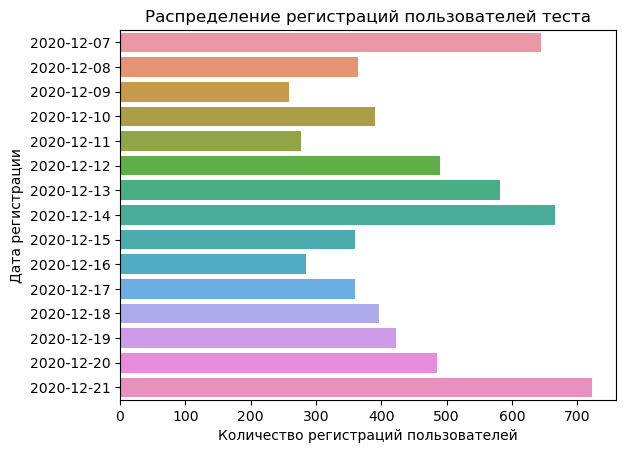

In [34]:
sns.countplot(data=new_users_system_test, y=new_users_system_test['first_date'].dt.date).set(
                                 title = "Распределение регистраций пользователей теста",
                                 ylabel = "Дата регистрации",
                                 xlabel = "Количество регистраций пользователей")
plt.show()

Можно заметить, что группы распределены неравномерно, так как в тестовой группе находится 43% пользователей от общего числа, а в контрольной - 57%. На графике можно наблюдать, что пик регистрации пользователей приходится на понедельники.

**Проверим следующие требования из ТЗ: ожидаемое количество участников (6000) и аудитория - 15% новых пользователей из региона EU:**

In [35]:
new_users_system_test.groupby('region')['region'].count()

region
APAC         72  
CIS          55  
EU           6351
N.America    223 
Name: region, dtype: int64

In [36]:
#всего новых пользователей из EU
count_total_EU = new_users[new_users['region'] == 'EU']['region'].count()
print(f'Количество зарегистрированных новых пользователей из EU: {count_total_EU}')

count_of_plan = int(new_users[new_users['region'] == 'EU']['region'].count()*0.15)
print(f'Расчетное количество (15%) новых пользователей из EU для аудитории теста: {count_of_plan}') 

#всего новых пользователей из EU в тесте
count_of_real = new_users_system_test.groupby('region')['region'].count()['EU']
print(f'Реальное количество новых пользователей из EU в тесте: {count_of_real}')

percent_of_real = count_of_real / count_total_EU
print(f'% новых пользователей из EU в тесте: {percent_of_real : .2%}')    

Количество зарегистрированных новых пользователей из EU: 46270
Расчетное количество (15%) новых пользователей из EU для аудитории теста: 6940
Реальное количество новых пользователей из EU в тесте: 6351
% новых пользователей из EU в тесте:  13.73%


На основе полученных данных можно сделать следующие наблюдения:

- Расчетное количество пользователей - 6940
- Реальное количество пользователей из региона EU в тесте - 6351 (составляет 13.73%, однако в ТЗ сказано о 15%)

Для того, чтобы результаты тестирования соответствовали ТЗ, необходимо удалить пользователей из других регионов.

#### Профили пользователей

**Напишем функцию, которая удалит данные теста о пользователях из других регионов, а также попавшихся в оба теста:**

In [37]:
def clear(dataframe):
    print('Количество пользователей теста до чистки:', dataframe['user_id'].nunique())
    user_not_EU = new_users_system_test.query('region != "EU"')['user_id']
    listok = list(duplicated_users_tests["user_id"].unique())
    dataframe_ok = dataframe.query('user_id not in @listok')
    dataframe_ok = dataframe_ok.query('user_id not in @user_not_EU')
    print('Количество пользователей теста после чистки:', dataframe_ok['user_id'].nunique())
    return dataframe_ok

**Очистим данные от "лишних" пользователей:**

In [38]:
events_system_test_clear = clear(events_system_test)
new_users_system_test_clear = clear(new_users_system_test)
participants_system_test_clear =  clear(participants_system_test)

Количество пользователей теста до чистки: 3675
Количество пользователей теста после чистки: 2594
Количество пользователей теста до чистки: 6701
Количество пользователей теста после чистки: 4749
Количество пользователей теста до чистки: 6701
Количество пользователей теста после чистки: 4749


**Посмотрим на распределение регистраций пользователей между группами тестирования:**

In [39]:
test_data_ok =  participants_system_test_clear.groupby('group').count()
test_data_ok['user_id'].sum()
test_data_ok['percent_of_group'] = test_data_ok['user_id']*100 / test_data_ok['user_id'].sum()
test_data_ok

,user_id,percent_of_group
group,,
A,2713,57.13
B,2036,42.87


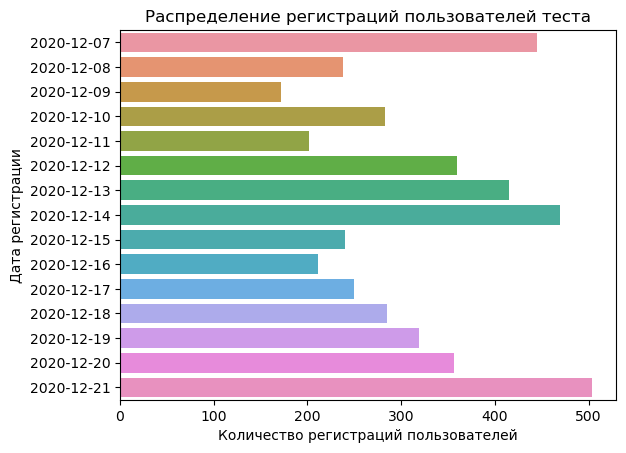

In [40]:
sns.countplot(data=new_users_system_test_clear, y=new_users_system_test_clear['first_date'].dt.date).set(
                                 title = "Распределение регистраций пользователей теста",
                                 ylabel = "Дата регистрации",
                                 xlabel = "Количество регистраций пользователей")
plt.show()

Очистка данных о пользователях никак не повлияла на распределение регистраций.

**Объединим таблицы событий с профилями пользователей теста, посчитаем лайфтайм и удалим данные, которые не подходят под условия:**

In [41]:
end_date = dt.datetime(2020, 12, 30).date()
horison_days = 14
first_dat = pd.to_datetime(end_date - timedelta(days=horison_days - 1),  format='%Y-%m-%d')
first_dat

Timestamp('2020-12-17 00:00:00')

С 18.12.2020 данные неполные. Необходимо их обработать:

In [42]:
# функция для вывода профиля пользователя со всеми данные
def events_and_profiles(dataframe_events, dataframe_new_users, dataframe_participants):
    data = dataframe_events.merge(dataframe_participants, how='left', on=['user_id'] )
    data = data.merge(dataframe_new_users[['user_id', 'first_date']], how='left', on=['user_id'])
    data['event_date'] = data['event_dt'].dt.date
    data['first_date'] = data['first_date'].dt.date
    data['lifetime'] = (data['event_date'] - data['first_date']).dt.days
    data = data[data['lifetime']<=13]
    data = data[data['first_date']<=  first_dat]
    return data

Для детального исследования необходимо сравнивать результаты исходных и очищенных данных:

In [43]:
# датафрейм с исходными данными
old_events_and_profiles = events_and_profiles(events_system_test, new_users_system_test, participants_system_test)

# датафрейм с "чистыми" данными
new_events_and_profiles = events_and_profiles(events_system_test_clear, new_users_system_test_clear, participants_system_test_clear)


display(f'Количество событий в исходном датасете - {len(old_events_and_profiles)}', old_events_and_profiles.head())
display(f'Количество событий в очищенном датасете - {len(new_events_and_profiles)}', new_events_and_profiles.head())

'Количество событий в исходном датасете - 14775'

,user_id,event_dt,event_name,details,group,first_date,event_date,lifetime
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,2020-12-07,2020-12-07,0
1,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,A,2020-12-07,2020-12-07,0
2,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,B,2020-12-07,2020-12-07,0
3,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99,A,2020-12-07,2020-12-07,0
4,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,B,2020-12-07,2020-12-07,0


'Количество событий в очищенном датасете - 10374'

,user_id,event_dt,event_name,details,group,first_date,event_date,lifetime
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,2020-12-07,2020-12-07,0
1,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,A,2020-12-07,2020-12-07,0
2,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,B,2020-12-07,2020-12-07,0
3,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,B,2020-12-07,2020-12-07,0
4,A9908F62C41613A8,2020-12-07 11:26:47,purchase,9.99,B,2020-12-07,2020-12-07,0


**Найдем количество активных пользователей в группах:**

In [44]:
print('Активные пользователи в исходных данных:', old_events_and_profiles.groupby('group')['user_id'].nunique())
print('Активные пользователи в обработанных данных: ', new_events_and_profiles.groupby('group')['user_id'].nunique())

Активные пользователи в исходных данных: group
A    1597
B    675 
Name: user_id, dtype: int64
Активные пользователи в обработанных данных:  group
A    1115
B    476 
Name: user_id, dtype: int64


**Наблюдения:** 

По исходным данным:

- В группе A - 1597 активных пользователей
- В группе B - 675 активных пользователей

По обработанным данным:

- В группе A - 1115 активных пользователей
- В группе B - 476 активных пользователей

**Посчитаем общее количество пользователей в группах теста после обработки пользователей по горизонту:**

In [45]:
old_users = new_users_system_test.query('first_date <=  @first_dat')['user_id'] 
old_groups = participants_system_test.query('user_id in @old_users').groupby('group').count().T

# расчет по обработанным данным
new_users = new_users_system_test_clear.query('first_date <=  @first_dat')['user_id']
new_groups = participants_system_test_clear.query('user_id in @new_users').groupby('group').count().T

display("Результаты по исходным данным:", old_groups)
display("Результаты по обработанным данным:", new_groups)

'Результаты по исходным данным:'

group,A,B
user_id,2674,1999


'Результаты по обработанным данным:'

group,A,B
user_id,1889,1396


Были обработаны пользователи, не прожившие полные 14 дней, и события, которые произошли после 17 декабря (свыше 14 лайфтайма).

- По исходным данным:

    Осталась информация о 4763 пользователях: в группе A - 2674, в группе B - 1999

- По обработанным данным:

    Осталась информация о 3285 пользователях: в группе A - 1889, в группе B - 1396

#### Проверка ожидаемого эффекта: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%

- конверсии в просмотр карточек товаров - событие `product_page`,
- просмотр корзины - `product_cart`,
- покупки - `purchase`

**Напишем функцию для подготовки данных для воронок:**

In [46]:
def funnels(events_and_profiles, group_df):
    # Группируем уникальных пользователей по событиям
    funnel = events_and_profiles.pivot_table(index = 'event_name', columns = 'group', values = 'user_id', aggfunc = 'nunique')
    funnel = pd.concat([funnel, group_df]).sort_values(by='B', ascending=False)
    
    funnel.drop('user_id', inplace=True, axis=0)
    # Добавляем расчетные колонки % конверсии от предыдущего события
    funnel['A_shift'] = funnel['A'].shift(1, axis=0)
    funnel['A_convers'] = funnel['A'] * 100 /  funnel['A_shift']
    funnel['B_shift'] = funnel['B'].shift(1, axis=0)
    funnel['B_convers'] = funnel['B'] * 100 /  funnel['B_shift']
    funnel['delta_%_convers'] =   funnel['B_convers'] - funnel['A_convers'] 
    
    funnel.drop(['A_shift', 'B_shift'], inplace=True, axis = 1)

    return funnel

**Построим воронки для двух датасетов:**

In [47]:
old_funnel = funnels(old_events_and_profiles,old_groups)
display('Воронка по исходным данным:', old_funnel)

fig = go.Figure()
fig.update_layout(title={'text' :'Воронка событий по группам A и B', 'x':0.55, 'xanchor': 'center'})
for event in ['A', 'B']:    
    fig.add_trace(go.Funnel(
    name = event,
    y=['Вошел в приложение', 'Страница товара', 'Корзина', 'Покупка'],
    x=old_funnel[event]))
fig.show() 

'Воронка по исходным данным:'

group,A,B,A_convers,B_convers,delta_%_convers
login,1597,674,NaN,NaN,NaN
product_page,1018,386,63.74,57.27,-6.47
product_cart,479,195,47.05,50.52,3.47
purchase,487,189,101.67,96.92,-4.75


In [48]:
new_funnel = funnels(new_events_and_profiles,new_groups)
display('Воронка по обработанным данным:', new_funnel)

fig = go.Figure()
fig.update_layout(title={'text' :'Воронка событий по группам A и B', 'x':0.55, 'xanchor': 'center'})
for event in ['A', 'B']:    
    fig.add_trace(go.Funnel(
    name = event,
    y=['Вошел в приложение', 'Страница товара', 'Корзина', 'Покупка'],
    x=new_funnel[event]))
fig.show() 

'Воронка по обработанным данным:'

group,A,B,A_convers,B_convers,delta_%_convers
login,1115,475,NaN,NaN,NaN
product_page,723,265,64.84,55.79,-9.05
product_cart,350,139,48.41,52.45,4.04
purchase,333,132,95.14,94.96,-0.18


#### Вывод:

На основе полученных результатов можно сделать следующие выводы:

- Имеется информация о 6701 участнике рассматриваемого теста: 3824 находятся в группе A и 2877 находятся в группе B

- Дата начала и окончания набора новых пользователей соответствуют техническому заданию

- Дата старта и окончания теста не соответствуют техническому заданию, так как тест законичился 30 декабря, а должен был 4 января. На это могли повлиять новогодние праздники

- Было обнаружено, что 1602 пользователя являлись участниками сразу двух тестов. Они могут исказить результаты, если их не обработать.

- Во время проведения тестирования в регионе EU проводилась акция `Christmas&New Year Promo`. Из-за этого определение зависимости улучшений от конкретных изменений становится довольно сложным, так как акция может повлиять на эти результаты

- Пользователей, которые попали сразу в обе группы теста, не было обнаружено

- Пользователи в группах распределены неравномерно: в тестовой группе находится 43% пользователей, а в контрольной - 57%

- Состав аудитории теста: исходное количество  участников - 6701, из которых 6351 из EU. Согласно техническому заданию аудитория должна состоять из 15% новых зарегистрированных пользователей из региона EU, однако их доля составила 13,73%. 

- Были обработаны пользователи, не прожившие полные 14 дней, и события, которые произошли после 14 лайфтайма.

После проведенных изменений было обнаружено, что они никак не повлияли на ситуацию: конверсия регистрации в покупку в группе В упала в 2 раза по сравнению с группой А. Необходимо провести более детальный анализ.

### Исследовательский анализ данных

#### Распределение количества событий на пользователя

**Для исходных данных:**

In [49]:
old_database = old_events_and_profiles.groupby('group')['user_id'].nunique().to_frame().T
old_database.rename(index={'user_id':'active_users'}, inplace=True)
old_database = pd.concat([old_groups, old_database]).T

old_database['nonactive_users'] = old_database['user_id'] - old_database['active_users'] # количество неактивных пользователей
old_database['perc_nonactive_users'] = old_database['nonactive_users'] * 100 / old_database['user_id'] # % неактивных

old_database.rename(columns={'user_id':'total_users'}, inplace=True)
old_database

,total_users,active_users,nonactive_users,perc_nonactive_users
group,,,,
A,2674,1597,1077,40.28
B,1999,675,1324,66.23


**Для обработанных данных:**

In [50]:
new_database = new_events_and_profiles.groupby('group')['user_id'].nunique().to_frame().T
new_database.rename(index={'user_id':'active_users'}, inplace=True)
new_database = pd.concat([new_groups, new_database]).T

new_database['nonactive_users'] = new_database['user_id'] - new_database['active_users'] # количество неактивных пользователей
new_database['perc_nonactive_users'] = new_database['nonactive_users'] * 100 / new_database['user_id'] # % неактивных

new_database.rename(columns={'user_id':'total_users'}, inplace=True)
new_database

,total_users,active_users,nonactive_users,perc_nonactive_users
group,,,,
A,1889,1115,774,40.97
B,1396,476,920,65.90


По полученным результатам можно сделать очень важное наблюдение, что в группе B 66% пользователей являются неактивными. Это может означать неэффективность изменений, которые тестируют в группе B.

**Посчитаем среднее значение количества событий для групп:**

In [51]:
print("Среднее количество событий на пользователя в группе А:") 
print(round(old_events_and_profiles.query('group == "A"').groupby('user_id')['event_name'].count().agg(['mean', 'median'])))
print()
print("Среднее количество событий на пользователя в группе B:")
print(round(old_events_and_profiles.query('group == "B"').groupby('user_id')['event_name'].count().agg(['mean', 'median'])))

Среднее количество событий на пользователя в группе А:
mean     7.00
median   6.00
Name: event_name, dtype: float64

Среднее количество событий на пользователя в группе B:
mean     6.00
median   5.00
Name: event_name, dtype: float64


При распределении событий между активными пользователями в группе A:

- Среднее количество событий на пользователя - 7
- Медианное количество событий на пользователя - 6

При распределении событий между активными пользователями в группе B:

- Среднее количество событий на пользователя - 6
- Медианное количество событий на пользователя - 5

**Посмотрим на распределение количества событий на пользователя при учете активных и неактивных пользователей:**

**Напишем функцию для подсчета количества событий по группам:**

In [52]:
def event_count(events_and_profiles, user_group_dataframe, group_test):

    event_counts = events_and_profiles.query('group == @group_test').groupby('user_id')['event_name'].count()
    event_counts = pd.concat([event_counts, pd.Series(0, index=np.arange(0, user_group_dataframe.loc[group_test,'nonactive_users']))])
    
    return event_counts

**Напишем функцию для подсчета среднего количества событий на пользователя и распределения событий по группам:**

In [53]:
def avg_events_users(dataA, dataB):
    print("Среднее количество событий на пользователя в группе А:", round(dataA.mean()))
    print("Среднее количество событий на пользователя в группе B:", round(dataB.mean()))
    plt.figure(figsize=(16, 5))

    ax1 = plt.subplot(1, 2, 1)
    dataA.hist(bins=20).set(title='Распределение событий пользователей группы А', 
                            xlabel = "Количество событий на пользователя")
    ax2 = plt.subplot(1, 2, 2)
    dataB.hist(bins=25).set(title='Распределение событий пользователей группы B', 
                              xlabel = "Количество событий на пользователя")
    plt.show()

    plt.figure(figsize=(18,5))
    plt.subplot(1, 2, 1)
    sns.boxplot(dataA).set(title='Распределение событий пользователей группы A', 
                            xlabel = "Количество событий на пользователя")
    plt.subplot(1, 2, 2)
    sns.boxplot(dataB).set(title='Распределение событий пользователей группы B', 
                            xlabel = "Количество событий на пользователя")
    plt.xticks(rotation=45)
    plt.show()

**Найдем разницу в количестве событий и среднее количество событий на пользователя по группам:**

Разница в количестве событий группы В и группы А -53.01%
p_значение: 0.0000
Среднее количество событий на пользователя в группе А: 4
Среднее количество событий на пользователя в группе B: 2


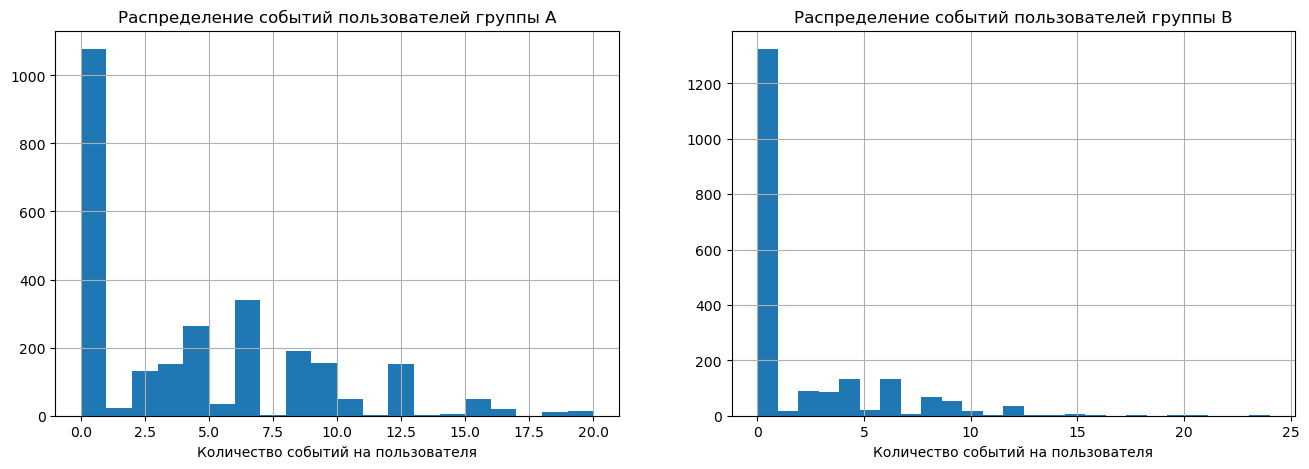

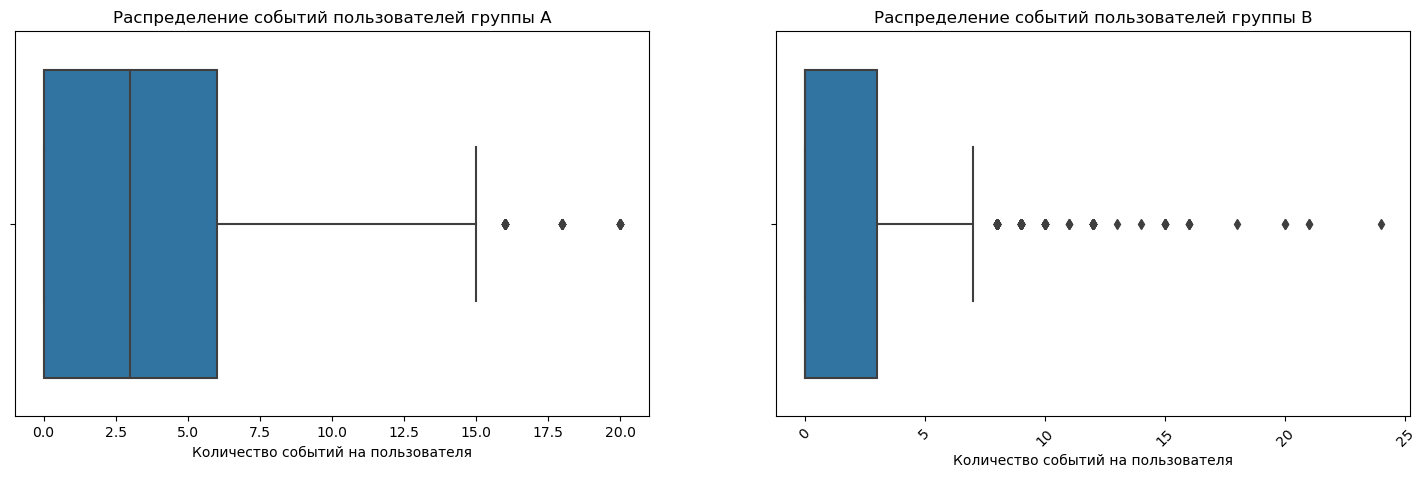

In [54]:
df_groupA = event_count(old_events_and_profiles, old_database, "A" )
df_groupB = event_count(old_events_and_profiles, old_database, "B" )

print("Разница в количестве событий группы В и группы А {0:.2%}".format((df_groupB.mean() / df_groupA.mean() - 1)))

# Расчет p-значения критерия Манна-Уитни
print('p_значение: {0:.4f}'.format(st.mannwhitneyu(df_groupA, df_groupB, True, "two-sided")[1]))

avg_events_users(df_groupA, df_groupB)

**Вывод:**

По полученным результатам можно сделать вывод, что группа A активнее, чем группа B. 66% пользователей в группе B являются неактивными (в группе А - 40%). Среднее значение количества событий на пользователя в группе А в два раза больше, чем в группе B. Разница в количестве событий на пользователя между группами A и B - 53%

При распределении событий между активными пользователями в группе A:

- Среднее количество событий на пользователя - 7
- Медианное количество событий на пользователя - 6

При распределении событий между активными пользователями в группе B:

- Среднее количество событий на пользователя - 6
- Медианное количество событий на пользователя - 5

#### Распределение числа событий в группах по дням

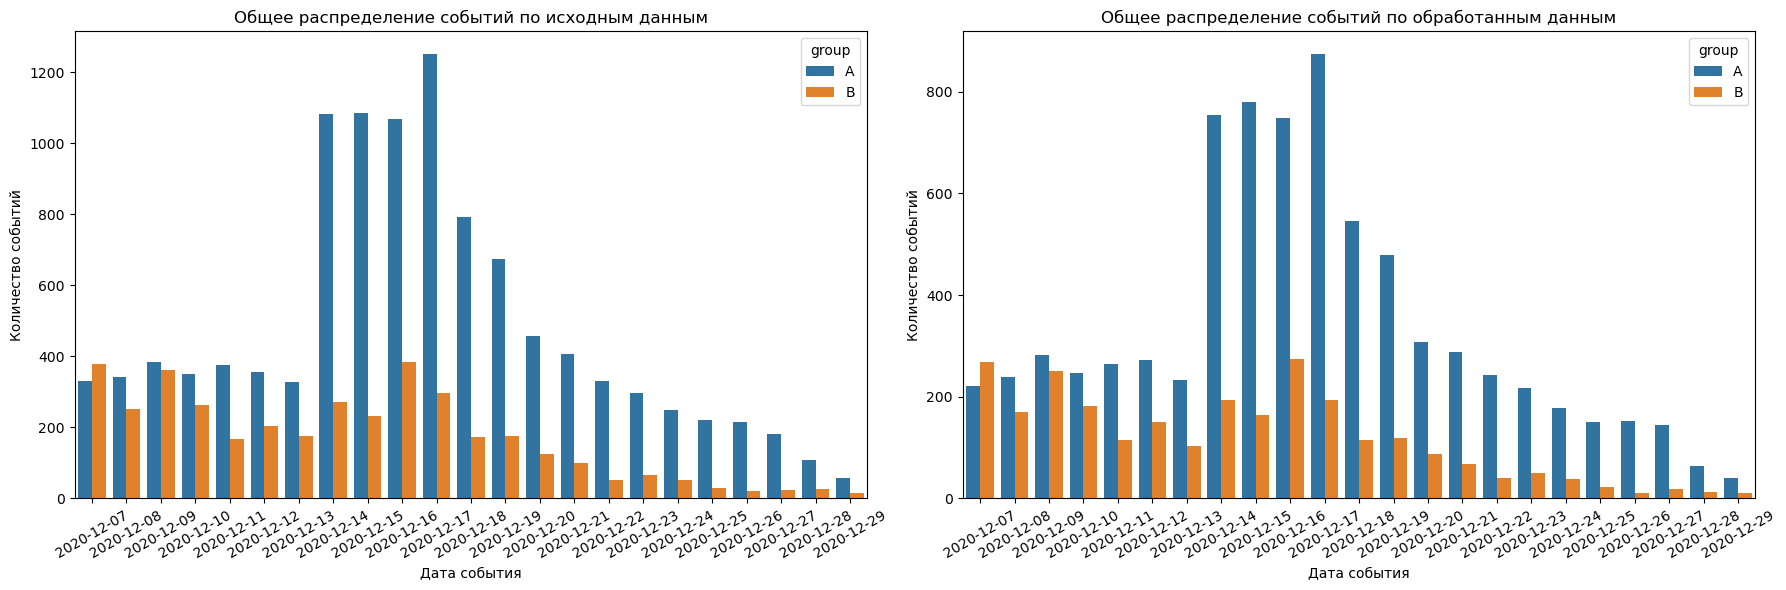

In [55]:
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
sns.countplot(data=old_events_and_profiles, x="event_date", hue='group' )
plt.title('Общее распределение событий по исходным данным')
plt.xlabel('Дата события')
plt.ylabel('Количество событий')
plt.xticks(rotation=30)


plt.subplot(1, 2, 2)
sns.countplot(data=new_events_and_profiles, x="event_date", hue='group')
plt.title('Общее распределение событий по обработанным данным')
plt.xlabel('Дата события')
plt.ylabel('Количество событий')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

С помощью графиков можно сделать следующие наблюдения:

- У группы A наблюдается резкий рост количества событий с 13 по 17 декабря 2020 года.
- Ближе к концу теста показатели уменьшаются. Можно предположить, что пик в середине теста был вызван подготовкой к новогодним праздникам.
- Акция, проводимая в регионе EU, сильно не повлияла на ситуацию, так как пик не приходится на момент старта акции.

#### Как меняется конверсия в воронке в выборках на разных этапах

**По исходным данным:**

In [56]:
old_funnel = funnels(old_events_and_profiles,old_groups)
display('Воронка по исходным данным:', old_funnel)

fig = go.Figure()
fig.update_layout(title={'text' :'Воронка событий по группам A и B', 'x':0.55, 'xanchor': 'center'})
for event in ['A', 'B']:    
    fig.add_trace(go.Funnel(
    name = event,
    y=['Вошел в приложение', 'Страница товара', 'Корзина', 'Покупка'],
    x=old_funnel[event]))
fig.show() 

'Воронка по исходным данным:'

group,A,B,A_convers,B_convers,delta_%_convers
login,1597,674,NaN,NaN,NaN
product_page,1018,386,63.74,57.27,-6.47
product_cart,479,195,47.05,50.52,3.47
purchase,487,189,101.67,96.92,-4.75


**По обработанным данным:**

In [57]:
new_funnel = funnels(new_events_and_profiles,new_groups)
display('Воронка по обработанным данным:', new_funnel)

fig = go.Figure()
fig.update_layout(title={'text' :'Воронка событий по группам A и B', 'x':0.55, 'xanchor': 'center'})
for event in ['A', 'B']:    
    fig.add_trace(go.Funnel(
    name = event,
    y=['Вошел в приложение', 'Страница товара', 'Корзина', 'Покупка'],
    x=new_funnel[event]))
fig.show() 

'Воронка по обработанным данным:'

group,A,B,A_convers,B_convers,delta_%_convers
login,1115,475,NaN,NaN,NaN
product_page,723,265,64.84,55.79,-9.05
product_cart,350,139,48.41,52.45,4.04
purchase,333,132,95.14,94.96,-0.18


Можно отметить, что конверсия постепенно уменьшается на каждом этапе. Наибольшее падение конверсии произошло на этапе "вошел в приложение - страница товара". Она составила примерно на 16% по исходным данным и на 20% по обработанным данным. Примерно 38% пользователей из группы A и 19% пользователей группы B дошли до страницы товара. 

Помимо этого, наблюдается, что конверсия "корзина-покупка" совсем небольшая. Большинство пользователей, которые переходят в корзину, совершают покупку товара. 

Можно считать, что увеличение конверсии на каждом этапе не подтвердилось. Она увеличивается только на этапе "вошел в приложение - страница товара".

#### Какие особенности данных нужно учесть, прежде чем приступать к A/B-тесту?

Следует учитывать следующие особенности:

- Количество участников в двух группах не должно сильно различаться
- Не должно быть сильного различия между метриками по группам
- Различие метрик не должно иметь статистической значимости
- Участник одной группы должен оставаться в одной группе до конца теста (исключить одинаковых пользователей в двух группах одновременно во избежания искажения результатов)

**Выполним проверку сформулированных особенностей:**

In [58]:
print(old_groups['A']* 100/old_groups['B'])
print()
print(new_groups['A']*100/new_groups['B'])

user_id   133.77
dtype: float64

user_id   135.32
dtype: float64


Остальные особенности были проверены на предыдущих этапах исследования.

По исходным данным:

- Группа A больше группы B на 33,7%

По обработанным данным:

- Группа А больше группы B на 35,3%

Пользователей, которые находятся сразу в двух группах, нет. 

Конверсия в события по группам превышает 1%, поэтому A/B-тест в целом уже не требуется для определения изменений.

В датасете присутствуют пользователи из другого региона. Это может исказить результаты A/B-теста.

#### Вывод:

По полученным результатам можно сделать вывод, что группа A активнее, чем группа B. 66% пользователей в группе B являются неактивными (в группе А - 40%). Среднее значение количества событий на пользователя в группе А в два раза больше, чем в группе B. Разница в количестве событий на пользователя между группами A и B - 53%

При распределении событий между активными пользователями в группе A:

- Среднее количество событий на пользователя - 7
- Медианное количество событий на пользователя - 6

При распределении событий между активными пользователями в группе B:

- Среднее количество событий на пользователя - 6
- Медианное количество событий на пользователя - 5

С помощью графиков можно сделать следующие наблюдения:

- У группы A наблюдается резкий рост количества событий с 13 по 17 декабря 2020 года.
- Ближе к концу теста показатели уменьшаются. Можно предположить, что пик в середине теста был вызван подготовкой к новогодним праздникам.
- Акция, проводимая в регионе EU, сильно не повлияла на ситуацию, так как пик не приходится на момент старта акции.

Можно отметить, что конверсия постепенно уменьшается на каждом этапе. Наибольшее падение конверсии произошло на этапе "вошел в приложение - страница товара". Она составила примерно на 16% по исходным данным и на 20% по обработанным данным. Примерно 40% пользователей из группы A и 20% пользователей группы B дошли до страницы товара. 
Помимо этого, наблюдается, что конверсия "корзина-покупка" совсем небольшая. Большинство пользователей, которые переходят в корзину, совершают покупку товара. 
Можно считать, что увеличение конверсии на каждом этапе не подтвердилось. Она увеличивается только на этапе "вошел в приложение - страница товара".

- Объем групп сильно различается: группа А на 33-35% больше группы B.
- Конверсия событий различается более чем на 1%.
- В датасете присутствует информация о пользователях из другого региона (не EU). Это может сказаться на результатах A/B-теста.

### Оценка результатов A/B-тестирования

#### Анализ результатов с помощью оценки статистической разницы z-критерием

Для проведения A/B-тестирования необходимо сформулировать гипотезы. Пусть 

- Нулевая гипотеза: Статистически значимые различия между конверсиями групп А и В присутствуют
- Альтернативная гипотеза: Статистически значимые различия между конверсиями групп А и В отсутствуют

Были выбраны такие гипотезы, так как на предыдущих этапах мы отмечали падение конверсии на разных этапах, однако следует провести тест. 

Возьмем коэффициент статистической значимости: alpha = 0.05

**Приступим к тестированию по исходным данным:**

Напишем функцию для теста:

In [59]:
def z_test (funnels, alpha, event):
    # критический уровень статистической значимости
    alpha = alpha 
    
    successes_A = funnels.loc[event, 'A']
    successes_B = funnels.loc[event, 'B']
    
    trials_A = funnels.loc['login', 'A']
    trials_B =  funnels.loc['login', 'B']

    p_A = successes_A/trials_A
    p_B = successes_B/trials_B

    p_total = (successes_A + successes_B) / (trials_A + trials_B)

    # разница пропорций в датасетах
    difference = p_A - p_B

    # Найдем z-критерий
    z_value = difference / mth.sqrt(p_total * (1 - p_total) * (1/trials_A + 1/trials_B))

    # Cтандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение равно:', p_value)

    if p_value < alpha:
        return f'Для события {event} с критический уровнем стат. значимости {alpha} не удалось отвергнуть нулевую гипотезу'
    else:
        return f'Для события {event} с критический уровнем стат. значимости {alpha} нулевую гипотезу следует отвергнуть'

**Событие `Страница товара`:**

In [60]:
z_test(old_funnel, 0.05, 'product_page')

p-значение равно: 0.0037153168216332855


'Для события product_page с критический уровнем стат. значимости 0.05 не удалось отвергнуть нулевую гипотезу'

**Событие `Корзина`:**

In [61]:
z_test(old_funnel, 0.05, 'product_cart')

p-значение равно: 0.6127932877614128


'Для события product_cart с критический уровнем стат. значимости 0.05 нулевую гипотезу следует отвергнуть'

**Событие `Покупка`:**

In [62]:
z_test(old_funnel, 0.05, 'purchase')

p-значение равно: 0.24278962671482107


'Для события purchase с критический уровнем стат. значимости 0.05 нулевую гипотезу следует отвергнуть'

**Приступим к тестированию по обработанным данным:**

**Событие `Страница товара`:**

In [63]:
z_test(new_funnel, 0.05, 'product_page')

p-значение равно: 0.000657678570669562


'Для события product_page с критический уровнем стат. значимости 0.05 не удалось отвергнуть нулевую гипотезу'

**Событие `Корзина`:**

In [64]:
z_test(new_funnel, 0.05, 'product_cart')

p-значение равно: 0.40023788955973894


'Для события product_cart с критический уровнем стат. значимости 0.05 нулевую гипотезу следует отвергнуть'

**Событие `Покупка`:**

In [65]:
z_test(new_funnel, 0.05, 'purchase')

p-значение равно: 0.4048860315899181


'Для события purchase с критический уровнем стат. значимости 0.05 нулевую гипотезу следует отвергнуть'

По исходным и обработанным данным можно отметить, что для события `product_page` статически значимые различия между конверсиями групп А и В наблюдаются, однако для событий `product_cart` и `purchase` статически значимых различий между конвериями групп А и В нет.

### Выводы

На основе полученных результатов можно сделать следующие выводы:

***На этапе изучения исходных данных было выявлено, что для анализа предоставлено 4 датасета. Было обнаружено:***

`events` - 440317 действий пользователей в период c 7 по 30 декабря 2020 года

Структура датафрейма:
    
- Столбец `user_id` — идентификатор пользователя
- Столбец `event_dt` — дата и время покупки
- Столбец `event_name` — тип события
- Столбец `details` — дополнительные данные о событии

В столбце `details` обнаружены пропуски в данных. Их следует оставить без изменения, так как они составляют значительную часть от общего объема данных.

`marketing_events` - календарь 14 маркетинговых событий на 2020 год

Структура датафрейма:
    
- Столбец `name` — название маркетингового события 
- Столбец `regions` — регионы, в которых будет проводиться рекламная кампания
- Столбец `start_dt` — дата начала кампании
- Столбец `finish_dt` — дата завершения кампании

`new_users` - данные о 61733 пользователях в период с 7 по 23 декабря 2020 года

Структура датафрейма:
    
- Столбец `user_id` — идентификатор пользователя
- Столбец `first_date` — дата регистрации
- Столбец `region` — регион пользователя
- Столбец `device` — устройство, с которого происходила регистрация

`participants` - данные о 18268 участниках тестов

Структура датафрейма:
    
- Столбец `user_id` — идентификатор пользователя
- Столбец `ab_test` — название теста
- Столбец `group` — группа пользователя

1602 участника тестирования попали в разные группы/тесты одновременно.

***На этапе предобработки данных в столбцах с датой были изменены типы данных на datetime.***

***На этапе оценки корректности проведения теста были сформулированы следующие выводы:***

- Имеется информация о 6701 участнике рассматриваемого теста: 3824 находятся в группе A и 2877 находятся в группе B

- Дата начала и окончания набора новых пользователей соответствуют техническому заданию

- Дата старта и окончания теста не соответствуют техническому заданию, так как тест законичился 30 декабря, а должен был 4 января. На это могли повлиять новогодние праздники

- Было обнаружено, что 1602 пользователя являлись участниками сразу двух тестов. Они могут исказить результаты, если их не обработать.

- Во время проведения тестирования в регионе EU проводилась акция `Christmas&New Year Promo`. Из-за этого определение зависимости улучшений от конкретных изменений становится довольно сложным, так как акция может повлиять на эти результаты

- Пользователей, которые попали сразу в обе группы теста, не было обнаружено

- Пользователи в группах распределены неравномерно: в тестовой группе находится 43% пользователей, а в контрольной - 57%

- Состав аудитории теста: исходное количество  участников - 6701, из которых 6351 из EU. Согласно техническому заданию аудитория должна состоять из 15% новых зарегистрированных пользователей из региона EU, однако их доля составила 13,73%. 

- Были обработаны пользователи, не прожившие полные 14 дней, и события, которые произошли после 14 лайфтайма.

После проведенных изменений было обнаружено, что они никак не повлияли на ситуацию: конверсия регистрации в покупку в группе В упала в 2 раза по сравнению с группой А. 

***На четвертом этапе исследования были сделаны следующие выводы:***

Группа A активнее, чем группа B. 66% пользователей в группе B являются неактивными (в группе А - 40%). Среднее значение количества событий на пользователя в группе А в два раза больше, чем в группе B. Разница в количестве событий на пользователя между группами A и B - 53%

При распределении событий между активными пользователями в группе A:

- Среднее количество событий на пользователя - 7
- Медианное количество событий на пользователя - 6

При распределении событий между активными пользователями в группе B:

- Среднее количество событий на пользователя - 6
- Медианное количество событий на пользователя - 5

С помощью графиков можно сделать следующие наблюдения:

- У группы A наблюдается резкий рост количества событий с 13 по 17 декабря 2020 года.
- Ближе к концу теста показатели уменьшаются. Можно предположить, что пик в середине теста был вызван подготовкой к новогодним праздникам.
- Акция, проводимая в регионе EU, сильно не повлияла на ситуацию, так как пик не приходится на момент старта акции.

Можно отметить, что конверсия постепенно уменьшается на каждом этапе. Наибольшее падение конверсии произошло на этапе "регистрация пользователей - страница товара". Она составила примерно на 16% по исходным данным и на 20% по обработанным данным. Примерно 40% пользователей из группы A и 20% пользователей группы B дошли до страницы товара. 
Помимо этого, наблюдается, что конверсия "корзина-покупка" совсем небольшая. Большинство пользователей, которые переходят в корзину, совершают покупку товара. 
Можно считать, что увеличение конверсии на каждом этапе не подтвердилось. Она увеличивается только на этапе "регистрация пользователей - страница товара".

- Объем групп сильно различается: группа А на 33-35% больше группы B.
- Конверсия событий различается более чем на 1%.
- В датасете присутствует информация о пользователях из другого региона (не EU). Это может сказаться на результатах A/B-теста.

***При проведении A/B-тестирования z-критерием нулевую гипотезу не удалось отвергнуть только для события `product_page`: По исходным и обработанным данным можно отметить, что для события `product_page` статически значимые различия между конверсиями групп А и В наблюдаются, однако для событий `product_cart` и `purchase` статически значимых различий между конвериями групп А и В нет.***

***Итог:***

Был проведен детальный анализ данных. Исследование состояло на основе исходных и обработанных данных, чтобы избежать искажения результатов. Во время проведения A/B-тестирования в регионе EU проходила акция, которая могла повлиять на результаты тестирования. Помимо этого, тестирование проводилось перед новогодними праздниками, поэтому ажиотаж пользователей может объясняться желанием приобрести подарки друзьям и родственникам, а не проведенными изменениями. Исходя из этого, можно считать, что результаты A/B-тестирования можно признать некачественными, так как множество факторов могли повлиять на них.